In [1]:
import IPython.display as ipd # load a local WAV file and PLAY!!!
from scipy.signal import butter , filtfilt
%matplotlib inline
%pylab inline
import os
import pandas as pd
import librosa
import librosa.display
import glob 
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow as tf
import keras


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import os, fnmatch

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools
from keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

from livelossplot import PlotLossesKeras # To plot the NN realtime!

from tqdm import tqdm

Populating the interactive namespace from numpy and matplotlib


In [2]:
PATH_A = 'inputsound/set_a/'
PATH_B = 'inputsound/set_b/'
MAX_AUDIO_DURATION = 12

# Low pass filter

*Low-frequency sounds are those whose dominant frequencies are less than 100 Hz, such as third and fourth heart sounds and the diastolic murmur of mitral stenosis. The murmur containing the highest frequency sound is aortic regurgitation, whose dominant frequencies are approximately 400 Hz. The principal frequencies of other sounds and murmurs are between 1 and 300 Hz.*

![Heart frequencies](images/heart_freq.jpg)

**FUNCTION TO GET THE AUDIOS FILTERED**
* signals = list where each index is an audiowhich has been filtered
* clases = list where each index is the class of the audio

In [3]:
def get_signals_filtered(path):
    signals,classes = [],[]
    # LPH, fc = 500Hz
    fc = 500
    sr = 22050
    w = fc/(sr/2)
    b,a = butter(3,w , btype = "lowpass")

    for file in glob.glob(path + "/*" ):
        # Not append unlabeled
        if file.split("\\")[-1].split("_")[0] not in ["Aunlabelledtest", "Bunlabelledtest"]:
            signal, sr = librosa.load(file, sr = 22050, res_type='kaiser_fast')
            x = filtfilt(b,a, signal)
            x = x/x.max()
            signals.append(x)
            
            classes.append(file.split("\\")[-1].split("_")[0])

    return signals,classes

signals,classes = get_signals_filtered("inputsound/set_a")

In [4]:
# EXAMPLE of noise
signal, sr = librosa.load('inputsound/set_a/normal__201103140135.wav', sr = 22050)
ipd.Audio(signal, rate = 22050)

In [5]:
# EXAMPLE: No filtered
signal, sr = librosa.load('inputsound/set_a/normal__201106221450.wav', sr = 22050)
ipd.Audio(signal, rate = 22050)

In [6]:
# filtered audio
print(classes[119])
ipd.Audio(signals[119], rate = 22050)

normal


In [7]:
# LPF compressed
def LPF(signal):    
    fc = 300
    sr = 22050
    w = fc/(sr/2)
    b,a = butter(3,w , btype = "lowpass")

    x = filtfilt(b,a, signal)
    x = x/x.max()

    return x

 # MFCC

**FUNCTION AUDIO_NORM**

* Normalize data.

In [8]:
def audio_norm(data):
    data = (data-min(data))/(max(data)-min(data)+0.0001)
    return data-0.5

**FUNCTION GET_FILENAMES**

Gets filenames if they are not in ["Aunlabelledtest", "Bunlabelledtest","artifact"]. Which results in:
 - {'artifact', 'extrahls', 'murmur', 'normal'}: for set_a
 - {'extrastole', 'murmur', 'normal'}: for set_b

In [10]:
def get_filenames(path):
    files = []
    for file in glob.glob(path + "/*"):
        if file.split("\\")[-1].split("_")[0] not in ["Aunlabelledtest", "Bunlabelledtest", "artifact"]:
            files.append(file.split("\\")[1])
    return files

**FUNCTION GET_MFCC**

Gets MFCC array for different sets.

In [31]:
def get_mfcc(path, file_names, duration = MAX_AUDIO_DURATION, sr=22050):
    
    input_length=sr*duration
    
    # function to load files and extract features
    data = []
    for file_name in tqdm(file_names):
        
        try:
            sound_file = path + file_name
            
            signal, sr = librosa.load( sound_file, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration 
            dur = librosa.get_duration(y = signal, sr=sr)
            
            # pad audio file same duration
            if (round(dur) < duration):
                y = librosa.util.fix_length(signal, input_length)                
            
            #normalized raw audio 
            signal_norm = audio_norm(signal)            
            
            #LPF
            X = LPF(signal_norm)
            #MFCC
            mfccs = np.mean(  librosa.feature.mfcc(y = X, sr=sr, n_mfcc=40).T  ,  axis=0)           
        
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)        
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

### Get files and mfccs

In [32]:
a_files  = get_filenames(PATH_A)
a_sounds = get_mfcc(path = PATH_A , file_names = a_files, duration = MAX_AUDIO_DURATION) #Same duration for each file
b_files  = get_filenames(PATH_B)
b_sounds = get_mfcc(path = PATH_B , file_names = b_files, duration = MAX_AUDIO_DURATION) #Same duration for each file

100%|████████████████████████████████████████████████████████████████████████████████| 461/461 [00:40<00:00, 11.44it/s]


### Get labels

{'artifact', 'extrahls', 'murmur', 'normal'}: for set_a

{'extrastole', 'murmur', 'normal'}: for set_b
* 0 = artifact
* 1 = normal
* 2 = abnormal

In [33]:
# All filenames together
files = a_files + b_files

In [34]:
labels = []
len_classes = 2
for file in files:
    if 'normal' in file:
        labels.append(0)
    else:
        labels.append(1)

In [35]:
X = np.concatenate((a_sounds,b_sounds))
y = np.asarray(labels)

# Train-test-split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,random_state=1000, shuffle=True)

y_train = np.array(keras.utils.to_categorical(y_train, len_classes)) 
y_test = np.array(keras.utils.to_categorical(y_test, len_classes))


In [37]:
print ("Labels shape: ", y.shape)
print ("Data size of the array: : %s" % y.size)
print ("")
print ("Audio data shape: ", X.shape)
print ("Data size of the array: : %s" % X.size)
print ("")
print ("Training data shape: ", X_train.shape)
print ("Training label shape: ", y_train.shape)
print ("")
print ("Validation data shape: ", X_test.shape)
print ("Validation label shape: ", y_test.shape)


Labels shape:  (545,)
Data size of the array: : 545

Audio data shape:  (545, 40, 1)
Data size of the array: : 21800

Training data shape:  (436, 40, 1)
Training label shape:  (436, 2)

Validation data shape:  (109, 40, 1)
Validation label shape:  (109, 2)


# NN Model 

In [42]:
model = Sequential()
model.add(Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True), input_shape=(40,1)))
model.add(Bidirectional(LSTM(units=32, dropout=0.2, return_sequences=False)))
model.add(Dense(len_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', 
             metrics=['acc'])

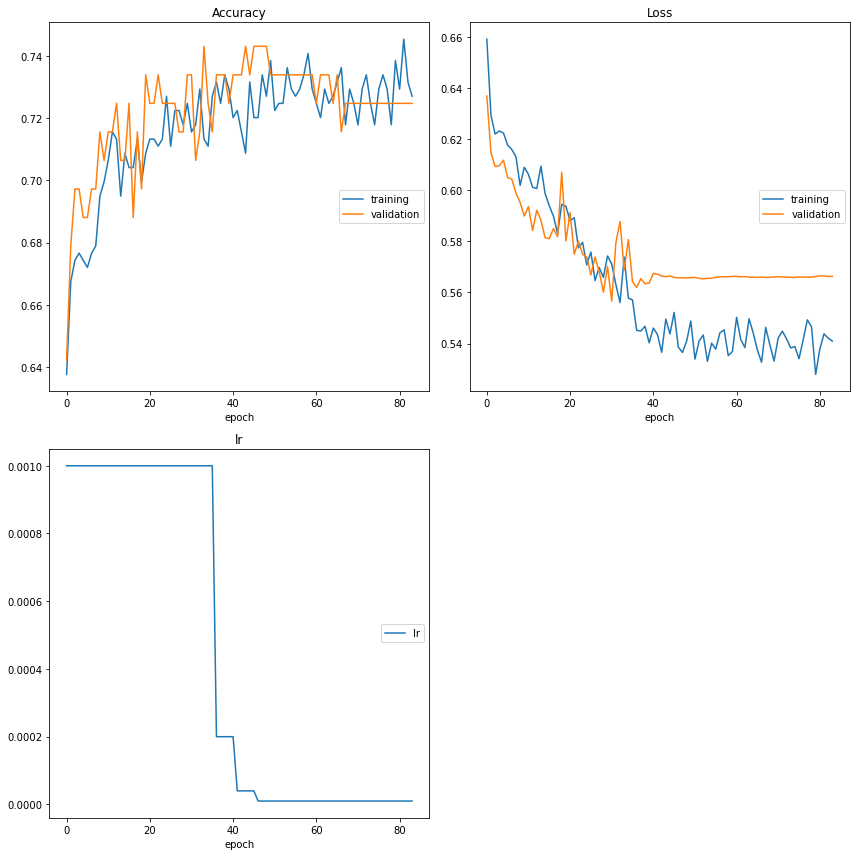

Accuracy
	training         	 (min:    0.638, max:    0.745, cur:    0.727)
	validation       	 (min:    0.642, max:    0.743, cur:    0.725)
Loss
	training         	 (min:    0.528, max:    0.659, cur:    0.541)
	validation       	 (min:    0.557, max:    0.637, cur:    0.566)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
14/14 [==============================] - 1s 53ms/step - loss: 0.5409 - acc: 0.7271 - val_loss: 0.5663 - val_acc: 0.7248


In [43]:
max_patience = 50
max_epochs = 200
max_batch = 32

early_stopping = EarlyStopping(monitor='val_acc', 
                               patience = max_patience, 
                               verbose=0, mode='max', 
                               restore_best_weights=False)

callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001),
                              early_stopping,
                              PlotLossesKeras()]

print("Training started..")
history = model.fit(X_train, y_train,
                   batch_size=max_batch,
                   epochs=max_epochs,
                   verbose=1,
                   validation_data=(X_test, y_test),
                   callbacks=callbacks)

In [44]:
results = model.evaluate(X_train, y_train, verbose=0) 
print ("Model training score: ")
print(f"   Train loss = {results[0]} \n   Train acc = {results[1]}")

score = model.evaluate(X_test, y_test, verbose=0) 
print ("Model testing score: ")
print(f"   Test loss = {score[0]} \n   Test acc = {score[1]}")

Model training score: 
   Train loss = 0.5270947217941284 
   Train acc = 0.7362385392189026
Model testing score: 
   Test loss = 0.5662552118301392 
   Test acc = 0.7247706651687622


# Results:

0. Fixed lenght & Normalize function & NO LPF: 30/100

    Model training score: 
       Train loss = 0.55611652135849 
       Train acc = 0.7316513657569885
    Model testing score: 
       Test loss = 0.5620374083518982 
       Test acc = 0.7247706651687622

1. Fixed lenght & Normalize function & LPF: 30/100

    Model training score: 
       Train loss = 0.5633388757705688 
       Train acc = 0.7224770784378052
    Model testing score: 
       Test loss = 0.5798124074935913 
       Test acc = 0.7339449524879456

2. No fixed length & No normalize: 50/200


       
3. No fixed length & No normalize  & LPF: 

    Model training score: 
       Train loss = 54 %
       Train acc = 73 %

    Model testing score: 
       Test loss = 65 %
       Test acc = 62 %
       
       
4. Fixed length & No normalize:

    Model training score: 
       Train loss = 54 %
       Train acc = 73 %

    Model testing score: 
       Test loss = 65 %
       Test acc = 62 %

In [ ]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)